In [7]:
import pandas as pd

df = pd.read_pickle("shoe_clip_embeddings.pkl")

print(df.columns)


Index(['title', 'otherImageIds', 'mainImageId', 'country', 'domainName',
       'bulletPoints', 'keywords', 'color', 'productType', 'style', 'image_id',
       'height', 'width', 'path', 'fullImagePath', 'metadataText',
       'clipTextEmbedding', 'clipImageEmbedding'],
      dtype='object')


In [9]:
# Create index - only doing this once
import os

from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

index_name = "clip-shoe-index"
dimension = 512  # CLIP embedding size

# Create index only once
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)


In [10]:
# Dump text embedding into pinecone

text_vectors = [
    (
        f"text-{row['image_id']}",
        row['clipTextEmbedding'],
        {
            "imageId": row['image_id'],
            "type": "text",
            "title": row["title"],
            "fullImagePath": row["fullImagePath"]
        }
    )
    for _, row in df.iterrows()
]

# Optional: batch upload (example with batch size = 200)
batch_size = 200
for i in range(0, len(text_vectors), batch_size):
    index.upsert(
        vectors=text_vectors[i:i+batch_size],
        namespace="clip-text"
    )


In [11]:
# Dump image embedding into pinecone

image_vectors = [
    (
        f"image-{row['image_id']}",
        row['clipImageEmbedding'],
        {
            "imageId": row['image_id'],
            "type": "image",
            "title": row["title"],
            "fullImagePath": row["fullImagePath"]
        }
    )
    for _, row in df.iterrows()
]

for i in range(0, len(image_vectors), batch_size):
    index.upsert(
        vectors=image_vectors[i:i+batch_size],
        namespace="clip-image"
    )

In [12]:
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, CLIPImageProcessor
from PIL import Image
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

def get_clip_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    return outputs.detach().numpy()[0]

def get_clip_text_embedding(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    outputs = model.get_text_features(**inputs)
    return outputs.detach().numpy()[0]

def embed_with_clip(text=None, image_path=None):
    if text:
        inputs = clip_tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=77
        )
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        return text_features.squeeze().cpu()

    if image_path:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_image_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        return image_features.squeeze().cpu()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
query_text = "colorful running shoes for kids"
query_embedding = get_clip_text_embedding(query_text)

results = index.query(
    namespace="clip-text",
    vector=query_embedding.tolist(),
    top_k=10,
    include_metadata=True
)


In [14]:
query_image_path = 'small/13/133d2255.jpg'
query_embedding = get_clip_image_embedding(query_image_path)

results = index.query(
    namespace="clip-image",
    vector=query_embedding.tolist(),
    top_k=10,
    include_metadata=True
)

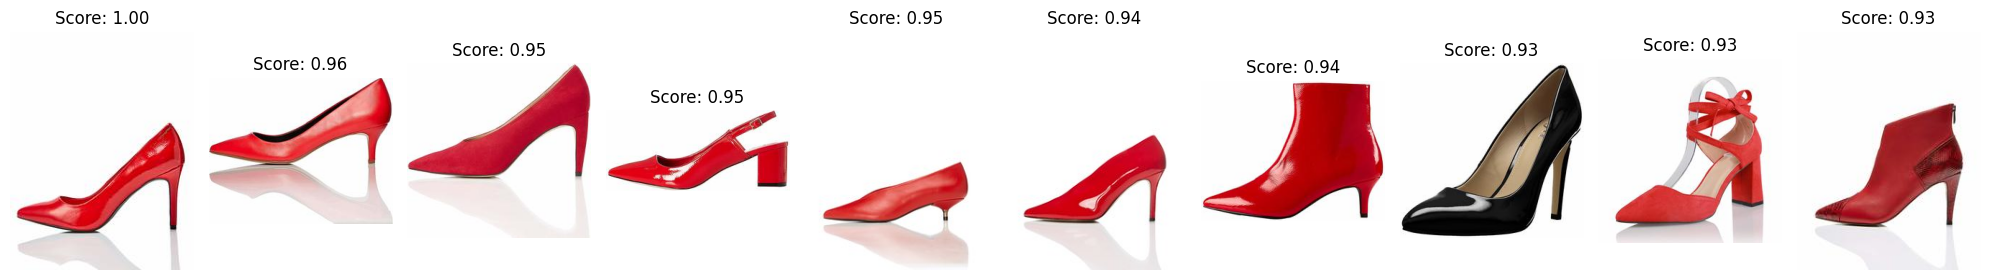

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, len(results["matches"]), figsize=(20, 4))

for ax, match in zip(axes, results["matches"]):
    path = match["metadata"]["fullImagePath"]
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.set_title(f"Score: {match['score']:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [30]:
from transformers import BlipProcessor, BlipForConditionalGeneration
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# BLIP captioning model setup
blip_caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base", use_fast=True)
blip_caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_caption_model.eval()


def generate_caption(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = blip_caption_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        out = blip_caption_model.generate(**inputs)
        return blip_caption_processor.decode(out[0], skip_special_tokens=True)

def embed_with_clip_text(text):
    inputs = clip_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    return text_features.squeeze().cpu().numpy()

def pinecone_text_query(query_vector, index, namespace="clip-image", top_k=6):
    results = index.query(
        vector=query_vector.tolist(),
        top_k=top_k,
        namespace=namespace,
        include_metadata=True
    )
    return results

In [48]:
import openai
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def generate_enhanced_query_gpt4o(user_query, image_caption):
    system_prompt = (
        "You are an assistant that takes a user's search query and a caption of a reference image. "
        "Return a single refined natural language query that merges both inputs. Lead with exactly what the user wants. "
        "For example: if they say they want something in a different color, lead with 'not color' and then add the important parts of the query. You may also try and rephrase the query to be exactly what the user is looking for - so an example would be 'high heels not in red'"
        "Your goal is to make a query for what the user wants that will give the best results when trying to find cosine similarity with CLIP embeddings"
    )

    user_prompt = f"""
User Query: "{user_query}"
Image Caption: "{image_caption}"
Refined Query:
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.3,
        max_tokens=50,
    )

    return response.choices[0].message.content.strip()


In [49]:
image_path = "small/13/133d2255.jpg"
query = "Find a shoe like this but in a different color"
caption = generate_caption(image_path)
print(f"[BLIP Caption] {caption}")
enhanced_query = generate_enhanced_query_gpt4o(query, caption)
print(enhanced_query)

[BLIP Caption] red high heel shoes
"Shoes like these red high heels but in a different color"


In [50]:
def blip_enhanced_clip_query(image_path, user_text, df, top_k=6, pinecone_index=None):
    # Step 1: Generate BLIP caption from image
    caption = generate_caption(image_path)
    print(f"[BLIP Caption] {caption}")

    # Step 2: Combine with user query
    # enhanced_query = f"{user_text.strip()}. {caption.strip()}"
    enhanced_query = generate_enhanced_query_gpt4o(user_text, caption)
    print(f"[Enhanced Query] {enhanced_query}")

    # Step 3: Embed enhanced query using CLIP
    query_vector = embed_with_clip_text(enhanced_query)

    # Step 4: Search Pinecone
    results = pinecone_text_query(query_vector, index=pinecone_index, top_k=top_k)

    # Step 5: Get matched image IDs and display
    matched_ids = [match["metadata"]["imageId"] for match in results["matches"]]
    matched_df = df[df["image_id"].isin(matched_ids)]

    return matched_df, results

# TODO: I could return the top 50 from here and then use BLIP to return the top 6

In [51]:
IMAGE_MAIN_DIRECTORY = "small/"
SHOE_PRODUCT_TYPES = ["SHOES", "SANDAL", "BOOT", "TECHNICAL_SPORT_SHOE"]
def show_image_results(results_df):
    fig, axes = plt.subplots(1, len(results_df), figsize=(4 * len(results_df), 5))
    if len(results_df) == 1:
        axes = [axes]
    for i, (_, row) in enumerate(results_df.iterrows()):
        img = Image.open(IMAGE_MAIN_DIRECTORY + row['path'])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{row.get('title', '')[:30]}...")
    plt.tight_layout()
    plt.show()


[BLIP Caption] red high heel shoes
[Enhanced Query] "high heel shoes not in red"


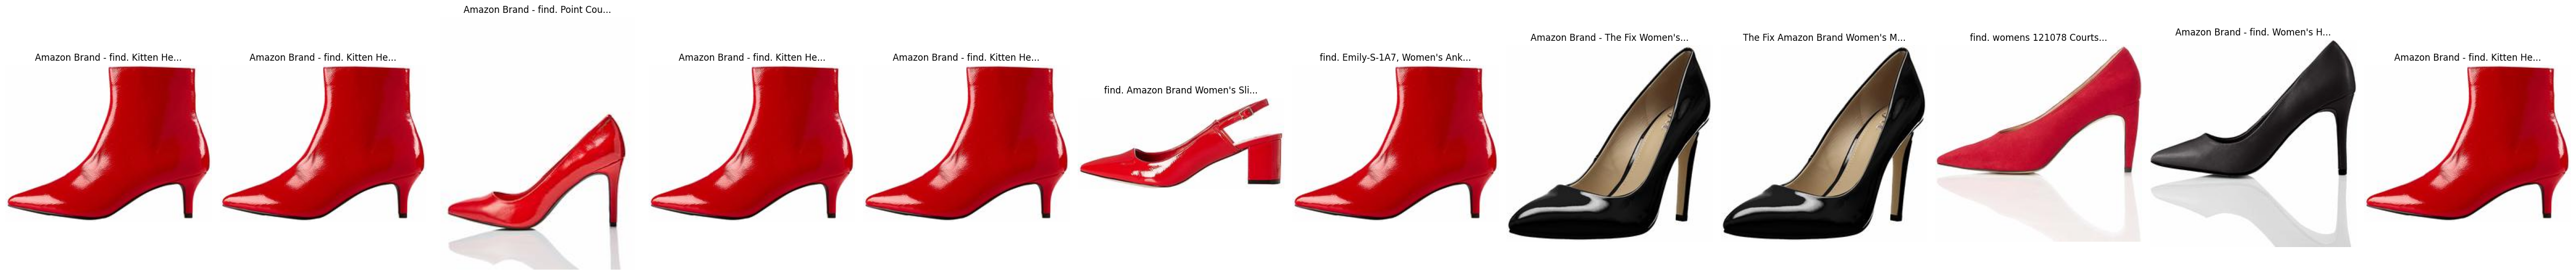

In [52]:
image_path = "small/13/133d2255.jpg"
query = "Find a shoe like this but in a different color"

shoeImages = df.copy()

matched_df, pinecone_scores = blip_enhanced_clip_query(
    image_path=image_path,
    user_text=query,
    df=shoeImages,
    top_k=6,
    pinecone_index=index
)

show_image_results(matched_df)


In [9]:
# Debugging pinecone embeddings

import pandas as pd
import os
from pinecone import Pinecone, ServerlessSpec

# --- Step 1: Load your data ---
df = pd.read_pickle("shoe_clip_embeddings.pkl")
image_ids_df = set(df["image_id"])

# --- Step 2: Connect to Pinecone ---
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index_name = "clip-shoe-index"
dimension = 512

# Create index if it doesn't exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)

# --- Step 3: Get all uploaded vector IDs from Pinecone ---

# --- New way to get existing vector IDs using metadata stats ---
stats = index.describe_index_stats()

def extract_ids_from_stats(stats, namespace, vector_type_prefix):
    ids = set()
    # stats['namespaces'][namespace]['vector_count'] and stats['namespaces'][namespace]['metadata'] are useful
    if namespace in stats['namespaces']:
        for vector_id in stats['namespaces'][namespace].get('metadata', {}):
            if vector_id.startswith(vector_type_prefix):
                ids.add(vector_id.replace(f"{vector_type_prefix}-", ""))
    return ids

existing_text_image_ids = extract_ids_from_stats(stats, "clip-text", "text")
existing_image_image_ids = extract_ids_from_stats(stats, "clip-image", "image")


# --- Step 4: Find missing ones ---
missing_text_ids = image_ids_df - existing_text_image_ids
missing_image_ids = image_ids_df - existing_image_image_ids


print(f"🧠 Total expected IDs: {len(image_ids_df)}")
print(f"✅ Text vectors in Pinecone: {len(existing_text_image_ids)}")
print(f"✅ Image vectors in Pinecone: {len(existing_image_image_ids)}")
print(f"❌ Missing text embeddings: {len(missing_text_ids)}")
print(f"❌ Missing image embeddings: {len(missing_image_ids)}")

🧠 Total expected IDs: 5992
✅ Text vectors in Pinecone: 0
✅ Image vectors in Pinecone: 0
❌ Missing text embeddings: 5992
❌ Missing image embeddings: 5992


In [10]:
print("Total rows in df:", len(df))
print("Unique image_ids:", df['image_id'].nunique())


Total rows in df: 11941
Unique image_ids: 5992
